## Pareto + RandomForest 帕累托最优

In [145]:
import time
import pandas as pd
import numpy as np

d1 = pd.read_csv("data/材料1.csv")
d2 = pd.read_csv("data/材料2.csv")
d3 = pd.read_csv("data/材料3.csv")
d4 = pd.read_csv("data/材料4.csv")

d1['材料'] = 1
d2['材料'] = 2
d3['材料'] = 3
d4['材料'] = 4

pd.set_option('future.no_silent_downcasting', True)

data = pd.concat([d1, d2, d3, d4])
data['励磁波形'] = data['励磁波形'].replace({'正弦波': 1, '三角波': 2, '梯形波': 3})

B_ = data.iloc[:, 4:-1].values

lst = ['温度', '频率', "磁芯损耗", '励磁波形']
for i in range(1024):
    lst.append(i)
lst.append('材料')
data.columns = lst

# std_flux = np.std(magnetic_flux_density, axis=1)  # 标准差
max_flux = np.max(B_, axis=1)  # 峰值
min_flux = np.min(B_, axis=1)

data['B_max'] = max_flux
data['B_min'] = min_flux

filter_data = data[
    ['温度', '频率', '励磁波形', '材料', 'B_max', 'B_min', '磁芯损耗']
]

# to = pd.DataFrame(filter_data)
# to.to_csv("~/Desktop/data.csv", index=False)
filter_data.head()

,温度,频率,励磁波形,材料,B_max,B_min,磁芯损耗
0,25,50030,1,1,0.028849,-0.028840,1997.955250
1,25,50020,1,1,0.031419,-0.031427,2427.749830
2,25,50020,1,1,0.035535,-0.035513,3332.725760
3,25,50020,1,1,0.040015,-0.040025,4502.908007
4,25,50030,1,1,0.045028,-0.045085,6063.023248


In [146]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

start_time = time.time()
X = data[['温度', '频率', '励磁波形', '材料', 'B_max', 'B_min']]  # 自变量 
y = data['磁芯损耗']  # 因变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ExtraTreesRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
end_time = time.time()

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)

print(f"mape: {mape:.2f}, mse: {mse:.2f}")

mape: 9.16, mse: 1365179387.41


In [147]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import *
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
import matplotlib.pyplot as plt

temperature_values = np.array([25, 50, 70, 90])
waveform_values = np.array([1, 2, 3])
material_values = np.array([1, 2, 3, 4])

lb = np.array([25, 50000, 1, 1, 0.01, -0.1])
ub = np.array([90, 500000, 3, 4, 0.1, -0.01])


class CoreOptimizationProblem(Problem):
    def __init__(self):
        # 决策变量 6 个，两个优化目标
        super().__init__(n_var=6, n_obj=2, n_constr=0, xl=lb, xu=ub)

    def _evaluate(self, X, out, *args, **kwargs):
        # X 是输入参数：温度、频率、励磁波形、材料、B_max、B_min
        temp, freq, waveform, material, B_max, B_min = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5]
        X = pd.DataFrame(X, columns=['温度', '频率', '励磁波形', '材料', 'B_max', 'B_min'])
        # 调用模型来预测磁芯损耗
        core_loss = model.predict(X)

        # 传输磁能计算公式
        transmitted_energy = B_max * freq

        # 目标是最小化磁芯损耗，最大化传输磁能
        out["F"] = np.column_stack([core_loss, -transmitted_energy])


In [148]:
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX

# 定义NSGA-II算法来进行多目标优化
algorithm = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

# 优化问题
problem = CoreOptimizationProblem()

In [149]:
res = minimize(problem,
               algorithm,
               ('n_gen', 200),  # 迭代次数
               verbose=True)

# 提取Pareto最优解
pareto_solutions = res.F
pareto_variables = res.X

# 输出最优解的变量和对应的目标值
print("Pareto最优解参数组合 (温度, 频率, 励磁波形, 材料, B_max, B_min):")
print(pareto_variables)

print("Pareto前沿对应的磁芯损耗和传输磁能:")
print(pareto_solutions)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     27 |             - |             -
     2 |      200 |     37 |  0.1530007691 |         nadir
     3 |      300 |     42 |  0.0142658705 |         ideal
     4 |      400 |     52 |  0.0061502497 |         ideal
     5 |      500 |     57 |  0.0068868174 |             f
     6 |      600 |     62 |  0.0255085048 |         nadir
     7 |      700 |     64 |  0.0078820888 |             f
     8 |      800 |     79 |  0.0143493518 |         ideal
     9 |      900 |     91 |  0.0157055515 |         ideal
    10 |     1000 |     96 |  0.0175073447 |         ideal
    11 |     1100 |    100 |  0.0041678982 |             f
    12 |     1200 |    100 |  0.0064820364 |         nadir
    13 |     1300 |    100 |  0.0051264017 |         nadir
    14 |     1400 |    100 |  0.0019747473 |             f
    15 |     1500 |    100 |  0.0048267124 |         nadir
    16 |     1600 |    100 |  0.0020231567 |            

In [150]:
# 从Pareto最优解中选择一个最佳解
# 选择磁芯损耗最小的解

best_solution_index = np.argmin(pareto_solutions[:, 0])
best_solution = pareto_variables[best_solution_index]
best_core_loss = pareto_solutions[best_solution_index, 0]
best_transmitted_energy = -pareto_solutions[best_solution_index, 1]

# 打印最优解
print(
    f"最优解的参数组合为: 温度={best_solution[0]}, 频率={best_solution[1]}, 励磁波形={best_solution[2]}, 材料={best_solution[3]}, B_max={best_solution[4]}, B_min={best_solution[5]}")
print(f"对应的磁芯损耗: {best_core_loss}")
print(f"对应的传输磁能: {best_transmitted_energy}")

最优解的参数组合为: 温度=89.96624500575865, 频率=79823.75418855531, 励磁波形=1.0000075788937808, 材料=1.193592667423479, B_max=0.018962303766468562, B_min=-0.019071825596633677
对应的磁芯损耗: 435.03359477960487
对应的传输磁能: 1513.642274703303


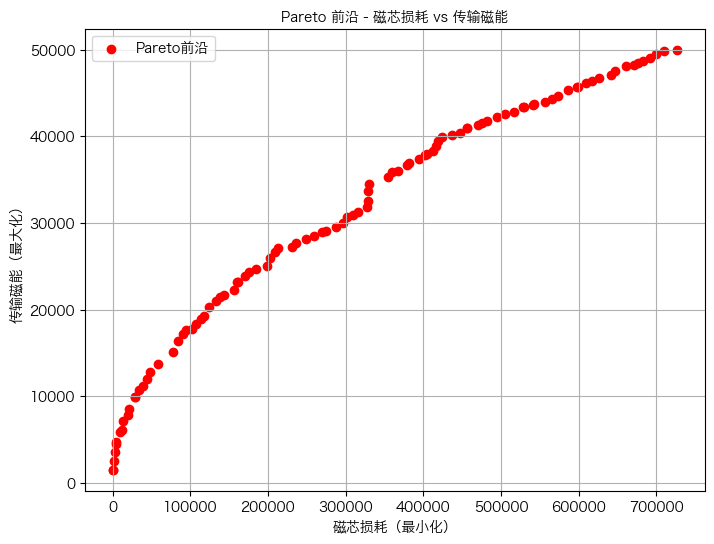

In [151]:
from matplotlib import font_manager

# 可视化Pareto前沿
font_path = '/System/Library/Fonts/Hiragino Sans GB.ttc'
my_font = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

plt.figure(figsize=(8, 6))
plt.scatter(pareto_solutions[:, 0], -pareto_solutions[:, 1], color='red', label="Pareto前沿")
plt.xlabel("磁芯损耗（最小化）", fontproperties=my_font)
plt.ylabel("传输磁能（最大化）", fontproperties=my_font)
plt.title("Pareto 前沿 - 磁芯损耗 vs 传输磁能", fontproperties=my_font)
plt.legend(prop=my_font)
plt.grid(True)
plt.show()